In [1]:
%%capture
!pip install transformers
!pip install pypinyin
!pip install jieba
!pip install paddlepaddle

In [2]:
import re,time,json,pickle
from collections import defaultdict
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import (BertTokenizer,BertConfig,BertModel)

from model.fusionDataset import FusionDataset

config = BertConfig.from_pretrained('AnchiBERT')
tokenizer = BertTokenizer.from_pretrained('AnchiBERT')
Anchibert = BertModel.from_pretrained('AnchiBERT',config=config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INFO:matplotlib.font_manager:generated new fontManager
Some weights of the model checkpoint at AnchiBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


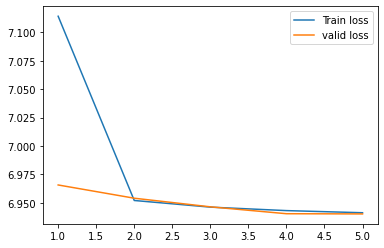

In [5]:
with open('result/fu_anchi_tra_Adam_128_01_60_30_10_5_6_110k_losses.pt','rb') as f:
    losses = pickle.load(f)
    
x = [_ for _ in range(1,len(losses[1])+1)]
plt.plot(x,losses[0],label='Train loss')
plt.plot(x,losses[1],label='valid loss')
plt.legend()

### Load Necessary preproceeded Data

In [4]:
with open('data/char_map.json','r') as f:
    ix2glyph = defaultdict(lambda : '_')
    ix2glyph[0] = '[PAD]'
    glyph2ix = defaultdict(lambda : 1)
    glyph2ix.update({'[CLS]':0,'[SEP]':0,'[PAD]':0})
    for i, k in enumerate(json.load(f).keys(),2):
        glyph2ix[k] = i
        ix2glyph[i] = k
with open('data/pinyin_map.json','r') as f:
    pinyin2ix = defaultdict(lambda : 1)
    pinyin2ix.update({'[CLS]':0,'[SEP]':0,'[PAD]':0})
    for i,k in enumerate(json.load(f).keys(),2):
        pinyin2ix[k] = i
with open('data/pos_tags.json','r') as f:
    pos2ix = defaultdict(lambda : 0)
    pos2ix.update(json.load(f))

# Decoder Section

In [5]:
from model.fusion_transformer import Fusion_Anchi_Trans_Decoder, Fusion_Anchi_Transformer, Anchi_Decoder,Anchi_Transformer

In [6]:
with open("couplet/test/in.txt",encoding='utf8') as f:
    te_in =  [row.strip().split() for row in f.readlines()]
# train 下联  
with open("couplet/test/out.txt",encoding='utf8') as f:
    te_out = [row.strip().split() for row in f.readlines()]

In [ ]:
config = { # for Fusion_Anchi_Trans_Decoder
    'max_position_embeddings':50,
    'hidden_size':768,
    'font_weight_path':'data/glyph_weight.npy',
    'pinyin_embed_dim':30, # trainable
    'pinyin_path':'data/pinyin_map.json',
    'tag_size':30,
    'tag_emb_dim':10, # trainable
    'layer_norm_eps':1e-12,
    'hidden_dropout':0.1,
    'nhead':12,
    'num_layers':6 , #6, trainable
    'output_dim':9110,# fixed
    'device':device,
}
model = Fusion_Anchi_Trans_Decoder(config)
model.load_state_dict(torch.load('result/fu_anchi_de_Adam_128_0001_60_6_30_10_110k.pt'))

In [8]:
from utils.generate_couplet import greedy_decode

In [ ]:
predict = greedy_decode(model=model,
                      bert=Anchibert,
                      tokenizer=tokenizer,
                      sent=te_in[0],
                      glyph2ix=glyph2ix,
                      pinyin2ix=pinyin2ix,
                      pos2ix=pos2ix,
                      ix2glyph=ix2glyph,
                        device=device)

In [47]:
' '.join(te_in[0]),' '.join(predict)

('腾 飞 上 铁 ， 锐 意 改 革 谋 发 展 ， 勇 当 千 里 马', '是 是 是 是 ， 是 是 是 是 是 是 是 ， 是 是 是 是 是')